In [ ]:
# %% Import Libraries

import warnings

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from pmdarima import ARIMA
from sklearn.metrics import mean_absolute_error, mean_squared_error

warnings.filterwarnings("ignore")

In [ ]:
# %% Load Cleaned Data

train_data = pd.read_csv("data/train_data_cleaned.csv")
test_data = pd.read_csv("data/test_data_cleaned.csv")

train_data["time"] = pd.to_datetime(train_data["time"])
test_data["time"] = pd.to_datetime(test_data["time"])

train_data.set_index("time", inplace=True)
test_data.set_index("time", inplace=True)

# Target Variable and Exogenous Inputs
y_train = train_data["demand"]
y_test = test_data["demand"]
exog_train = train_data[["temp", "dwpt", "price"]]
exog_test = test_data[["temp", "dwpt", "price"]]

In [ ]:
# %% Rolling Forecast Setup

horizon = 24  # 24-hour horizon
steps = len(y_test) // horizon  # Number of rolling windows
print(f"Number of rolling forecast steps: {steps}")

# Initialize lists for forecasts
arima_forecast = []
arima_exog_forecast = []
drift_forecast_values = []

Number of rolling forecast steps: 7


In [ ]:
# %% Rolling Out-of-Sample Forecasting

for i in range(0, len(y_test) - horizon + 1, horizon):
    rolling_y_train = pd.concat([y_train, y_test.iloc[:i]])
    rolling_exog_train = pd.concat([exog_train, exog_test.iloc[:i]])
    rolling_exog_test = exog_test.iloc[i : i + horizon]
    rolling_y_test = y_test.iloc[i : i + horizon]

    # --- 1. ARIMA Model (No Exogenous Inputs) ---
    arima_model = ARIMA(order=(1, 1, 1), seasonal_order=(0, 1, 1, 24))
    arima_results = arima_model.fit(rolling_y_train)
    arima_forecast.extend(arima_results.predict(n_periods=horizon))

    # --- 2. ARIMA Model with Exogenous Inputs ---
    arima_exog_model = ARIMA(order=(1, 1, 1), seasonal_order=(0, 1, 1, 24))
    arima_exog_results = arima_exog_model.fit(
        rolling_y_train, exogenous=rolling_exog_train
    )
    arima_exog_forecast.extend(
        arima_exog_results.predict(n_periods=horizon, exogenous=rolling_exog_test)
    )

    # --- 3. Drift Forecast ---
    slope = (rolling_y_train.iloc[-1] - rolling_y_train.iloc[0]) / len(rolling_y_train)
    drift_forecast_values.extend(
        [rolling_y_train.iloc[-1] + slope * (j + 1) for j in range(horizon)]
    )

# Convert forecasts to Series
arima_forecast = pd.Series(arima_forecast, index=y_test.index[: len(arima_forecast)])
arima_exog_forecast = pd.Series(
    arima_exog_forecast, index=y_test.index[: len(arima_exog_forecast)]
)
drift_forecast_series = pd.Series(
    drift_forecast_values, index=y_test.index[: len(drift_forecast_values)]
)

In [ ]:
# %% Naive Forecasting Technique

# Naive forecast: replicate the last observed value for each step
naive_forecast = y_test.shift(1).fillna(method="bfill")

# Evaluate naive forecast
naive_mae = mean_absolute_error(y_test, naive_forecast)
naive_rmse = np.sqrt(mean_squared_error(y_test, naive_forecast))

print(f"Naive Forecast MAE: {naive_mae:.4f}")
print(f"Naive Forecast RMSE: {naive_rmse:.4f}")

Naive Forecast MAE: 0.4391
Naive Forecast RMSE: 0.6168


In [ ]:
# %% Evaluate Forecast Performance

mae_arima = mean_absolute_error(y_test[: len(arima_forecast)], arima_forecast)
mae_arima_exog = mean_absolute_error(
    y_test[: len(arima_exog_forecast)], arima_exog_forecast
)
mae_drift = mean_absolute_error(
    y_test[: len(drift_forecast_series)], drift_forecast_series
)

print("\n--- Forecast Performance ---")
print(f"MAE (ARIMA): {mae_arima:.4f}")
print(f"MAE (ARIMA with Exogenous Inputs): {mae_arima_exog:.4f}")
print(f"MAE (Drift Forecast): {mae_drift:.4f}")
print(f"MAE (Naive Forecast): {naive_mae:.4f}")


--- Forecast Performance ---
MAE (ARIMA): 0.3350
MAE (ARIMA with Exogenous Inputs): 0.3350
MAE (Drift Forecast): 0.4352
MAE (Naive Forecast): 0.4391


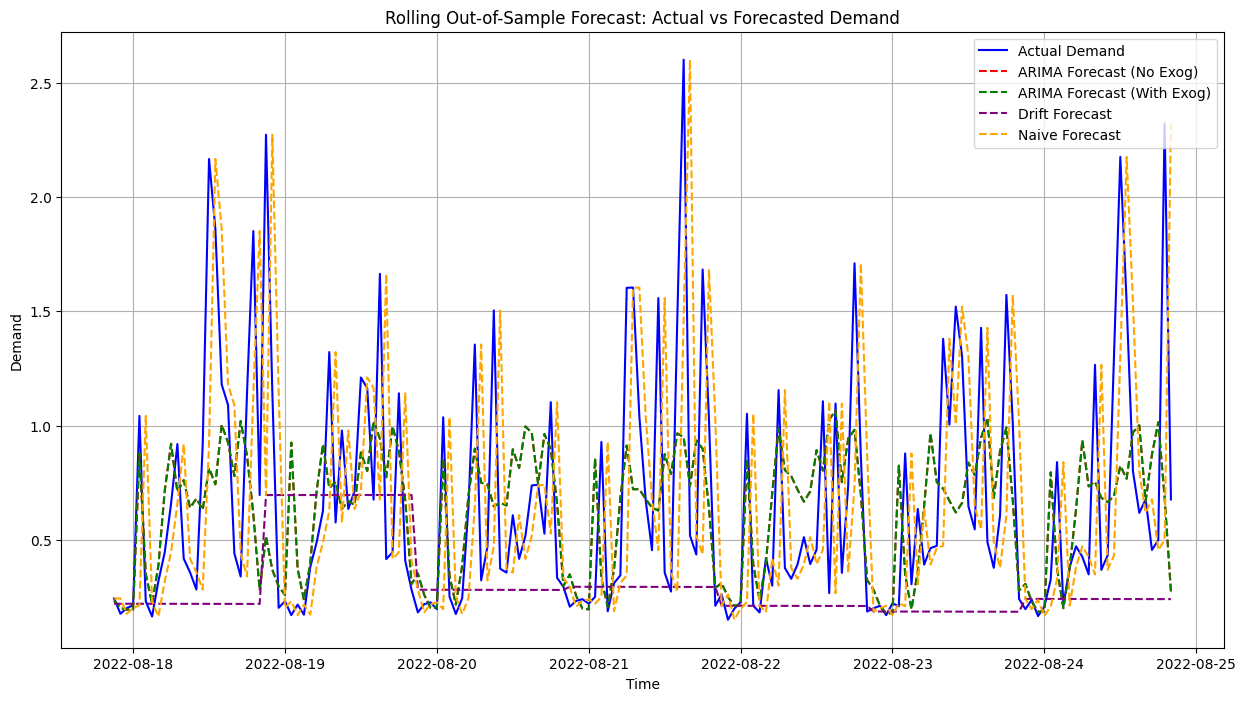

In [ ]:
# %% Visualize Forecasts

plt.figure(figsize=(15, 8))
plt.plot(y_test, label="Actual Demand", color="blue")
plt.plot(arima_forecast, label="ARIMA Forecast (No Exog)", linestyle="--", color="red")
plt.plot(
    arima_exog_forecast,
    label="ARIMA Forecast (With Exog)",
    linestyle="--",
    color="green",
)
plt.plot(drift_forecast_series, label="Drift Forecast", linestyle="--", color="purple")
plt.plot(naive_forecast, label="Naive Forecast", linestyle="--", color="orange")

plt.title("Rolling Out-of-Sample Forecast: Actual vs Forecasted Demand")
plt.xlabel("Time")
plt.ylabel("Demand")
plt.legend()
plt.grid()
plt.show()

In [ ]:
# %% Final Comparison of All Models

print("\n--- Final Model Comparison ---")
print(f"MAE (ARIMA): {mae_arima:.4f}")
print(f"MAE (ARIMA with Exogenous Inputs): {mae_arima_exog:.4f}")
print(f"MAE (Drift Forecast): {mae_drift:.4f}")
print(f"MAE (Naive Forecast): {naive_mae:.4f}")

# Determine the best-performing model
mae_dict = {
    "ARIMA": mae_arima,
    "ARIMA with Exogenous Inputs": mae_arima_exog,
    "Drift Forecast": mae_drift,
    "Naive Forecast": naive_mae,
}

best_model = min(mae_dict, key=mae_dict.get)
print(f"\nThe best-performing model is: {best_model}")


--- Final Model Comparison ---
MAE (ARIMA): 0.3350
MAE (ARIMA with Exogenous Inputs): 0.3350
MAE (Drift Forecast): 0.4352
MAE (Naive Forecast): 0.4391

The best-performing model is: ARIMA
